# Assignment 6  
## Applied Machine Learning

Andrew Chan 
EBE869

This assignment uses the `Suicide Rates Overview 1985 to 2016` dataset from Kaggle: https://www.kaggle.com/russellyates88/suicide-rates-overview-1985-to-2016. This assumes that you have downloaded the dataset in `master.csv` which is in the same directory as this notebook.

# 1. [20 pts] What is the dependent variable you decided? Why?

The dependent variable will be generated from the `suicides/100k pop`. We have chosen to use this versus `suicides_no` because this is normalized to population versus an absolute number of suicides. This will help provide a better prediction so that the model does not skew towards larger countries which may naturally have more suicides. 

## Preprocessing
The assingment states to use the "let's get back to the pre-processed dataset Suicide Rates Overview 1985 to 2016 file", thus we repeat the preprocessing steps here:

In [1]:
import pandas as pd
import math
import numpy as np

# Locate and load the data file
df = pd.read_csv('master.csv')

# Sanity check
print(f'N rows={len(df)}, M columns={len(df.columns)}')
df.head()

N rows=27820, M columns=12


,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers


### Adjust the gdp_for_year ($) from string to float.

In [2]:
df[' gdp_for_year ($) ']

0         2,156,624,900
1         2,156,624,900
2         2,156,624,900
3         2,156,624,900
4         2,156,624,900
              ...      
27815    63,067,077,179
27816    63,067,077,179
27817    63,067,077,179
27818    63,067,077,179
27819    63,067,077,179
Name:  gdp_for_year ($) , Length: 27820, dtype: object

In [3]:
df[' gdp_for_year ($) '] = df[' gdp_for_year ($) '].str.replace(',', '')
df[' gdp_for_year ($) '] = df[' gdp_for_year ($) '].astype(float) 
df[' gdp_for_year ($) ']

0        2.156625e+09
1        2.156625e+09
2        2.156625e+09
3        2.156625e+09
4        2.156625e+09
             ...     
27815    6.306708e+10
27816    6.306708e+10
27817    6.306708e+10
27818    6.306708e+10
27819    6.306708e+10
Name:  gdp_for_year ($) , Length: 27820, dtype: float64

# 2. [20 pts] Set the dependent variable into two categories based on a defensible criteria. 
(Hint: skirts of the probability density function)

To attempt a machine learning solution we will turn this into a binary classification problem of `low suicide rate` versus `high suicide rate`. Framing the problem this way will allow us to train a classifier. 

The steps to take will be the following:
1. We will use the dependent variable `suicides/100k pop`
2. Then calculate the 1st quartile (above 0.75, left skirt) `suicides_first_quartile`
3. Convert the data into a binary classification problem such that   
    a. If the value is > than `suicides_first_quartile` then convert to **`high suicide rate`**  
    b. If the value is < than `suicides_first_quartile` then convert to **`low suicide rate`**   

### Convert dependent variable to binary values

<AxesSubplot:>

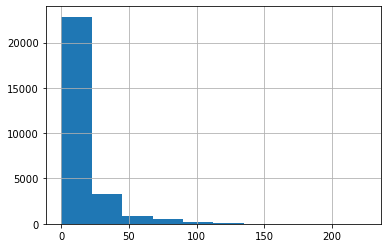

In [4]:
df["suicides/100k pop"].hist()

In [5]:
suicides_first_quartile = df["suicides/100k pop"].quantile(0.75)
suicides_first_quartile

16.62

We will create a modify `suicides/100k pop` as follows:  
* All values larger than or equal to `suicides_first_quartile` will be labelled with `high suicide rate` 
* All values smaller than `suicides_first_quartile` will be labelled with `low suicide rate` 

In [6]:
def isHigh(x, val):
    if x > val:
        return 'high suicide rate'
    else:
        return 'low suicide rate'
df['suicides/100k pop'] = df['suicides/100k pop'].apply(isHigh, args=[suicides_first_quartile])
df['suicides/100k pop'].value_counts()

low suicide rate     20866
high suicide rate     6954
Name: suicides/100k pop, dtype: int64

In [7]:
df.head()

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,low suicide rate,Albania1987,NaN,2.156625e+09,796,Generation X
1,Albania,1987,male,35-54 years,16,308000,low suicide rate,Albania1987,NaN,2.156625e+09,796,Silent
2,Albania,1987,female,15-24 years,14,289700,low suicide rate,Albania1987,NaN,2.156625e+09,796,Generation X
3,Albania,1987,male,75+ years,1,21800,low suicide rate,Albania1987,NaN,2.156625e+09,796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,low suicide rate,Albania1987,NaN,2.156625e+09,796,Boomers


### Removal redundant features

#### Remove `suicides_no`

`suicides_no` is highly correlated with with `suicides/100k pop`. Since `suicides/100k pop` was chosen as the dependent variable, it does not make sense to use `suicides_no` since `suicides/100k pop` is $$\frac{suicides\_no}{population/100000}$$ which is a derived attribute. 

Another reason why I chose to keep `suicides/100k pop` is because it helps **normalize suicides by population**. A large country may have many suicides because there are more people that live there, but a smaller country may have more suicides per population. 

In [8]:
df = df.drop(['suicides_no'], axis=1)

#### Remove `gdp_for_year ($)`

`gdp_for_year ($)` is highly correlated with with `gdp_per_capita ($)`. Since `gdp_per_capita ($)` was chosen as the dependent variable, it does not make sense to use `gdp_for_year ($)` since `gdp_per_capita ($)` is $$\frac{gdp\_for\_year ($)}{population}$$ which is a derived attribute.


Another reason why I chose to keep `gdp_per_capita ($)` is because it helps **normalize GDP by population**. A large country may have more gross domestic product because there are more people that live there, but a smaller country may have more gdp per capita. 

In [9]:
df = df.drop([' gdp_for_year ($) '], axis=1)

#### Remove `country-year`

Since `country-year` already is derived from `country` and `year`, it is redundant to include the `country-year`. Thus, we drop `country-year`.

I also chose to keep `country` and `year` because upon one-hot encoding, there will be **N countries** + **M years** columns versus **N x M** additional columns, which should help with computational speed. 

In [10]:
df = df.drop(['country-year'], axis=1)

#### Remove target variable

In [11]:
df_no_target = df.drop(['suicides/100k pop'], axis=1)

In [12]:
df_no_target

,country,year,sex,age,population,HDI for year,gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,312900,NaN,796,Generation X
1,Albania,1987,male,35-54 years,308000,NaN,796,Silent
2,Albania,1987,female,15-24 years,289700,NaN,796,Generation X
3,Albania,1987,male,75+ years,21800,NaN,796,G.I. Generation
4,Albania,1987,male,25-34 years,274300,NaN,796,Boomers
...,...,...,...,...,...,...,...,...
27815,Uzbekistan,2014,female,35-54 years,3620833,0.675,2309,Generation X
27816,Uzbekistan,2014,female,75+ years,348465,0.675,2309,Silent
27817,Uzbekistan,2014,male,5-14 years,2762158,0.675,2309,Generation Z
27818,Uzbekistan,2014,female,5-14 years,2631600,0.675,2309,Generation Z


### Most Frequent imputation

For all values with NaN, we will replace with most frequent

In [13]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy="most_frequent") 
df_no_target[:] = imp.fit_transform(df_no_target)

In [14]:
df_no_target

,country,year,sex,age,population,HDI for year,gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,312900,0.713,796,Generation X
1,Albania,1987,male,35-54 years,308000,0.713,796,Silent
2,Albania,1987,female,15-24 years,289700,0.713,796,Generation X
3,Albania,1987,male,75+ years,21800,0.713,796,G.I. Generation
4,Albania,1987,male,25-34 years,274300,0.713,796,Boomers
...,...,...,...,...,...,...,...,...
27815,Uzbekistan,2014,female,35-54 years,3620833,0.675,2309,Generation X
27816,Uzbekistan,2014,female,75+ years,348465,0.675,2309,Silent
27817,Uzbekistan,2014,male,5-14 years,2762158,0.675,2309,Generation Z
27818,Uzbekistan,2014,female,5-14 years,2631600,0.675,2309,Generation Z


In [15]:
final_features = df_no_target.columns

In [16]:
final_features

Index(['country', 'year', 'sex', 'age', 'population', 'HDI for year',
       'gdp_per_capita ($)', 'generation'],
      dtype='object')

### Normalization and Standardization

In [17]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_no_target[['year', 'population', 'HDI for year', 'gdp_per_capita ($)']] = scaler.fit_transform(df_no_target[['year', 'population', 'HDI for year', 'gdp_per_capita ($)']])

### One hot encoding of all nominal features

In [18]:
from sklearn.preprocessing import OneHotEncoder
X = df_no_target[['country','year','sex','age','population','HDI for year','gdp_per_capita ($)','generation']].values


In [19]:
ohe = OneHotEncoder()
X = ohe.fit_transform(X[:,[0,2,3,7]].reshape(-1,4)).toarray()

# 3. [20 pts] Develop your classification model(s) to solve your defined problem.

We will create a model using Logistic Regression to get probabilities of suicide rates since logistic regression calculates value between [0,1].

Set the x and y values:

In [20]:
df_y = df['suicides/100k pop']
y = df_y.values
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [21]:
X_train, X_test, y_train, expected = train_test_split(X, y, test_size = 0.2, random_state=0)

In [22]:
from sklearn.linear_model import LogisticRegression
pipe_lr = LogisticRegression(random_state=14,
               penalty='l1',
               solver='liblinear',
               class_weight='balanced',
               multi_class='auto',
               max_iter=10000)
pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)

# 4. [20 pts] Evaluate (and report) the model performance(s) using some of the standard techniques (e.g. 80-20 split, 10-fold cross validation, etc.).

### 80-20 split has accuracy of `0.8909058231488138`

In [23]:
X_train, X_test, y_train, expected = train_test_split(X, y, test_size = 0.2, random_state=0)
pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)

In [24]:
print(f'Classification report for classifier {pipe_lr}:\n{metrics.accuracy_score(expected, y_pred)}\n')

Classification report for classifier LogisticRegression(class_weight='balanced', max_iter=10000, penalty='l1',
                   random_state=14, solver='liblinear'):
0.8909058231488138



### 10 fold cross validation has mean accuracy of `0.6949676491732568`

In [25]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=10).split(X, y)
scores = []
for k, (train, test) in enumerate(kfold):
     pipe_lr.fit(X[train], y[train])
     score = pipe_lr.score(X[test], y[test])
     scores.append(score)
     print('Fold: %2d, Acc: %.3f' % (k+1, score))
np.mean(scores)


Fold:  1, Acc: 0.759
Fold:  2, Acc: 0.649
Fold:  3, Acc: 0.667
Fold:  4, Acc: 0.615
Fold:  5, Acc: 0.689
Fold:  6, Acc: 0.676
Fold:  7, Acc: 0.696
Fold:  8, Acc: 0.661
Fold:  9, Acc: 0.699
Fold: 10, Acc: 0.838


0.6949676491732568

# 5. [20 pts] Using your classifier model, what is the predicted category of your dependent variable for the input: "year=2000, generation=Generation X, age=20, gender=male"?

In [26]:
input = { 'year':[2000],
         'generation':['Generation X'],
         'age':['15-24 years'],
         'sex':['male'] 
}

df_input = pd.DataFrame(input,columns = ['country', 'year', 'sex', 'age', 'population', 'HDI for year',
       'gdp_per_capita ($)', 'generation'])

In [27]:
df_input

,country,year,sex,age,population,HDI for year,gdp_per_capita ($),generation
0,NaN,2000,male,15-24 years,NaN,NaN,NaN,Generation X


#### Imputation

In [28]:
imp.transform(df_input)

array([['Austria', 2000, 'male', '15-24 years', 24000, 0.713, 1299,
        'Generation X']], dtype=object)

In [29]:
df_input[:] = imp.transform(df_input)

In [30]:
df_input

,country,year,sex,age,population,HDI for year,gdp_per_capita ($),generation
0,Austria,2000,male,15-24 years,24000,0.713,1299,Generation X


#### Standardization

In [31]:
df_input[['year', 'population', 'HDI for year', 'gdp_per_capita ($)']] = scaler.transform(df_input[['year', 'population', 'HDI for year', 'gdp_per_capita ($)']])

#### One-hot

In [32]:
X_input = X = df_input[['country','year','sex','age','population','HDI for year','gdp_per_capita ($)','generation']].values

X_input = ohe.transform(X_input[:,[0,2,3,7]].reshape(-1,4)).toarray()

In [33]:
df_input[['country','year','sex','age','population','HDI for year','generation']]

,country,year,sex,age,population,HDI for year,generation
0,Austria,-0.148588,male,15-24 years,-0.465473,-0.324557,Generation X


## ANSWER: 

Prediction is `high suicide rate`

In [34]:
pipe_lr.predict(X_input[0].reshape(1, -1))

array(['high suicide rate'], dtype=object)

# 6. [20 pts bonus] Using your (perhaps a different?) model, what is the actual probability of a "Generation X 20-year-old male living in a country with 40000 gdp_per_capita" would commit suicide?

In [35]:
input = {'generation':['Generation X'],
         'gdp_per_capita ($)':[40000],
         'age':['15-24 years'],
         'sex':['male'] 
}

df_input = pd.DataFrame(input,columns = ['country', 'year', 'sex', 'age', 'population', 'HDI for year',
       'gdp_per_capita ($)', 'generation'])

In [36]:
df_input

,country,year,sex,age,population,HDI for year,gdp_per_capita ($),generation
0,NaN,NaN,male,15-24 years,NaN,NaN,40000,Generation X


### Imputation

In [37]:
imp.transform(df_input)

array([['Austria', 2009, 'male', '15-24 years', 24000, 0.713, 40000,
        'Generation X']], dtype=object)

In [38]:
df_input[:] = imp.transform(df_input)

In [39]:
df_input

,country,year,sex,age,population,HDI for year,gdp_per_capita ($),generation
0,Austria,2009,male,15-24 years,24000,0.713,40000,Generation X


#### Standardization

In [40]:
df_input[['year', 'population', 'HDI for year', 'gdp_per_capita ($)']] = scaler.transform(df_input[['year', 'population', 'HDI for year', 'gdp_per_capita ($)']])

#### One-hot

In [41]:
X_input = X = df_input[['country','year','sex','age','population','HDI for year','gdp_per_capita ($)','generation']].values

X_input = ohe.transform(X_input[:,[0,2,3,7]].reshape(-1,4)).toarray()

In [42]:
df_input[['country','year','sex','age','population','HDI for year','generation']]

,country,year,sex,age,population,HDI for year,generation
0,Austria,0.914124,male,15-24 years,-0.465473,-0.324557,Generation X


#### Prediction Probability

In [43]:
pipe_lr.predict_proba(X_input[0].reshape(1, -1))

array([[0.90675194, 0.09324806]])

In [44]:
pipe_lr.predict(X_input[0].reshape(1, -1))

array(['high suicide rate'], dtype=object)

## ANSWER: 
Prediction Probability is thus `0.90675194` for `high suicide rate`.